Alignment Red Filter

In [6]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from astropy.io import fits
import os
from photutils.centroids import centroid_com, centroid_2dg  #load centroid libraries
from astropy.visualization import ZScaleInterval, ImageNormalize


Ficheiros encontrados:
m57__2025-09-16_22-21-26_Red_0303.fits
m57__2025-09-16_22-23-06_Red_0304.fits
m57__2025-09-16_22-23-39_Red_0305.fits
m57__2025-09-16_22-24-12_Red_0306.fits
m57__2025-09-16_22-24-44_Red_0307.fits
m57__2025-09-16_22-25-17_Red_0308.fits
m57__2025-09-16_22-25-50_Red_0309.fits
m57__2025-09-16_22-26-22_Red_0310.fits
m57__2025-09-16_22-26-55_Red_0311.fits
m57__2025-09-16_22-27-27_Red_0312.fits
m57__2025-09-16_22-28-00_Red_0313.fits
m57__2025-09-16_22-28-33_Red_0314.fits
m57__2025-09-16_22-29-05_Red_0315.fits
m57__2025-09-16_22-29-38_Red_0316.fits
m57__2025-09-16_22-30-11_Red_0317.fits
center1: [227.1083606  871.75830365]
[222.59644308 865.00789677]


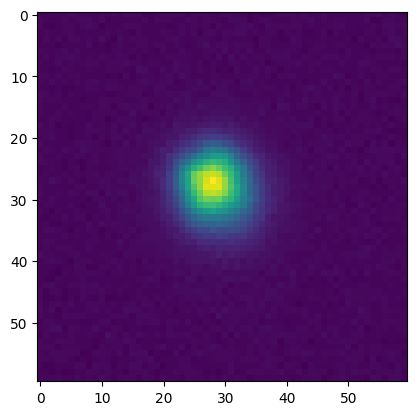

In [7]:
dir = "m57_red/"
fits_files = sorted([f for f in os.listdir(dir) if f.startswith("m57__2025") and f.endswith(".fits")])
# Carrega os headers de todos os ficheiros
head = [fits.getheader(os.path.join(dir, f)) for f in fits_files]
print("Ficheiros encontrados:")
for f in fits_files:
    print(f)

## Obtain rough position with the mouse
pos0 = [224,864] #imagem 303
pos1 = [224,880] #imagem 304
pos2 = [229,871]
pos3 = [226,871]
pos4 = [226,871]
pos5 = [226,871]
pos6 = [226,871]
pos7 = [224,866]
pos8 = [224,866]
pos9 = [219,852]
pos10 = [219,852]
pos11 = [219,850]
pos12 = [219,850]
pos13 = [219,850] #imagem 316
pos14 = [219,849] #imagem 317 (reference image for all images alignment )



positions = [pos0, pos1, pos2, pos3, pos4, pos5, pos6, pos7, pos8, pos9, pos10,
             pos11, pos12, pos13, pos14]
indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

science_dir = "m57_red_reduced"
science_calibrated_red = []
for file in os.listdir(science_dir):
    if file.endswith(".fits"):  
        filepath = os.path.join(science_dir, file)
        image = fits.getdata(filepath)
        science_calibrated_red.append(image)
        
subdata = [
    science_calibrated_red[idx][pos[1]-30:pos[1]+30, pos[0]-30:pos[0]+30]
    for idx, pos in zip(indices, positions)
]


plt.imshow(subdata[13])


centers = {}
ccenters = {}

for i, (sub, pos) in enumerate(zip(subdata, positions), start=0):
    centers[i] = centroid_2dg(sub) + pos - [30, 30]
    ccenters[i] = centroid_com(sub) + pos - [30, 30]

print(f"center1: {centers[2]}")
#print(ccenters["ccenter15"])

center_original=centers[0]
print(center_original)

In [8]:
dir = "m57_red_alignment/"

for i in range(0, 14):

    data = science_calibrated_red[i]

    # pegar o centróide correspondente (ex: center5, center6, ...)
    center = centers[i]

    # shift em y depois em x
    shifted_y = np.roll(data, -int(np.round(center[1] - center_original[1])), axis=0)
    shifted_x = np.roll(shifted_y, -int(np.round(center[0] - center_original[0])), axis=1)


    head_i = head[i]
    head_i['PROCESS'] = 'shifted'

    fits.writeto(f'{dir}m57_red_{i}_shift.fits', shifted_x, head_i, overwrite=True)

    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13


Alignment Blue Filter

Ficheiros encontrados:
m57__2025-09-16_22-00-10_Blue_0273.fits
m57__2025-09-16_22-01-52_Blue_0274.fits
m57__2025-09-16_22-02-25_Blue_0275.fits
m57__2025-09-16_22-02-57_Blue_0276.fits
m57__2025-09-16_22-03-30_Blue_0277.fits
m57__2025-09-16_22-04-03_Blue_0278.fits
m57__2025-09-16_22-04-35_Blue_0279.fits
m57__2025-09-16_22-05-08_Blue_0280.fits
m57__2025-09-16_22-05-41_Blue_0281.fits
m57__2025-09-16_22-06-13_Blue_0282.fits
m57__2025-09-16_22-06-46_Blue_0283.fits
m57__2025-09-16_22-07-19_Blue_0284.fits
m57__2025-09-16_22-07-51_Blue_0285.fits
m57__2025-09-16_22-08-24_Blue_0286.fits
m57__2025-09-16_22-08-57_Blue_0287.fits


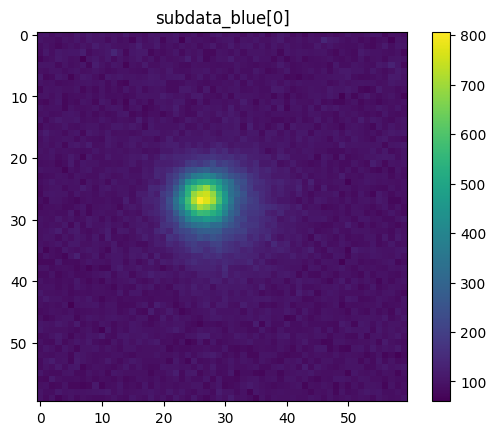

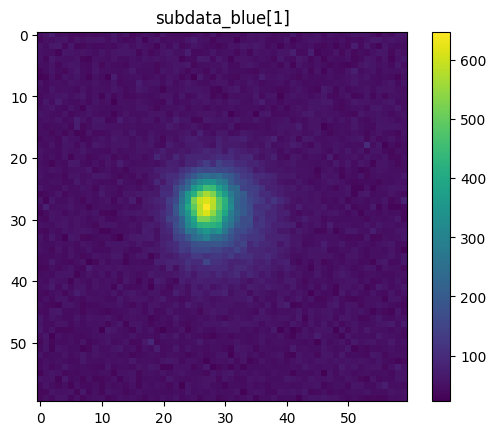

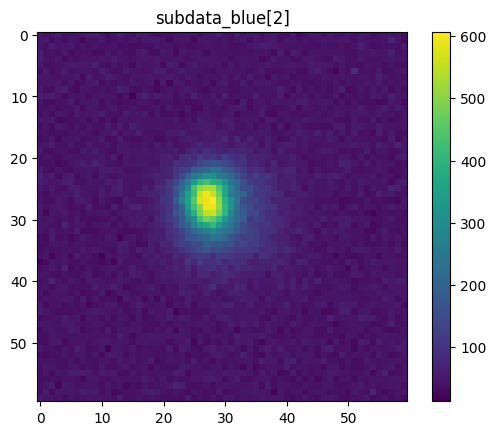

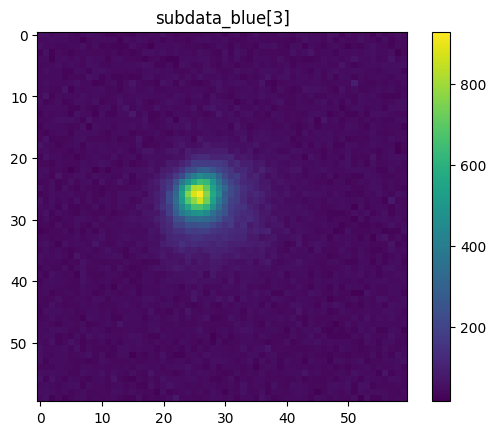

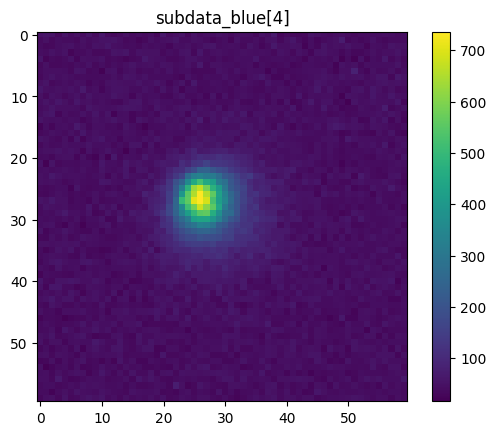

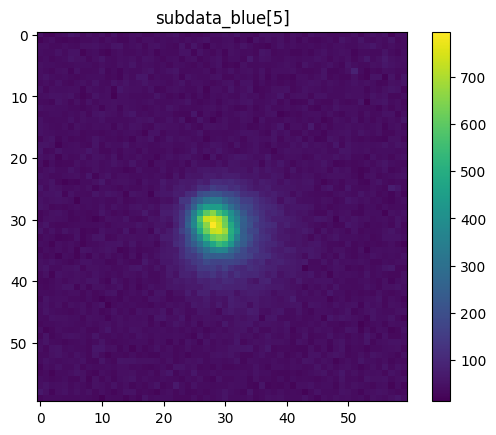

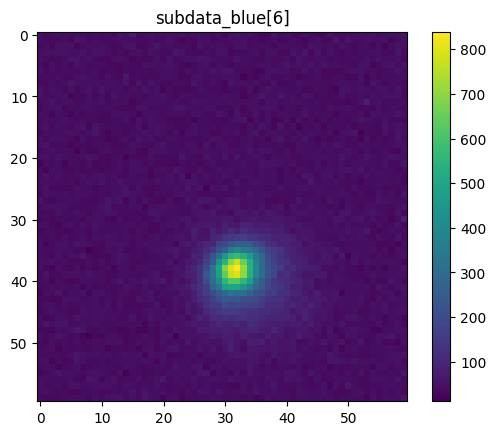

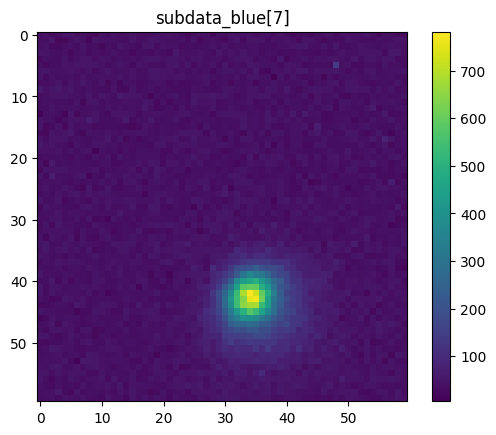

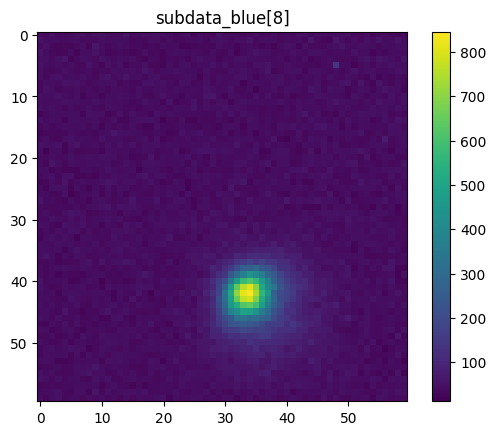

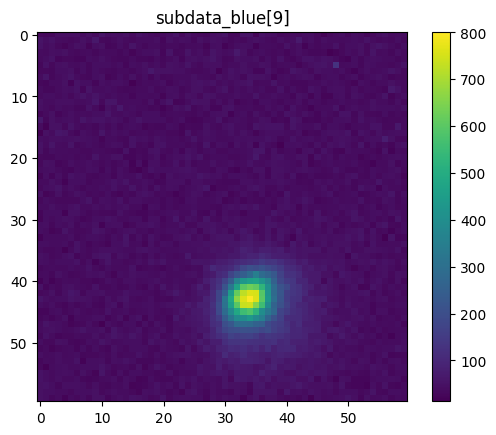

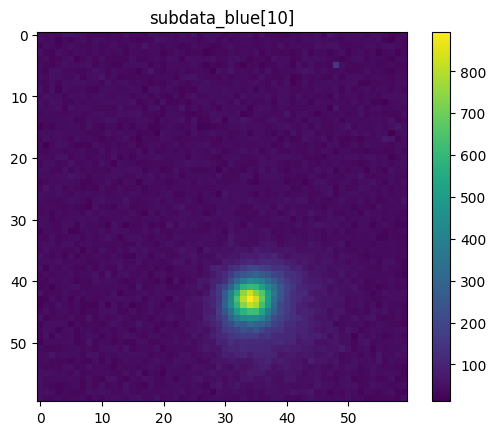

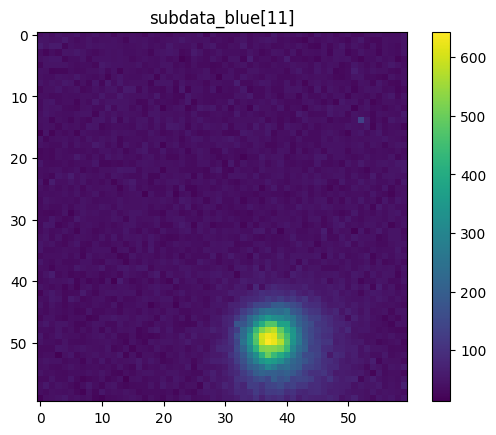

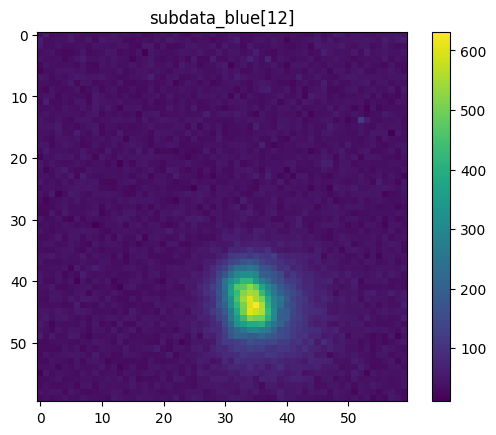

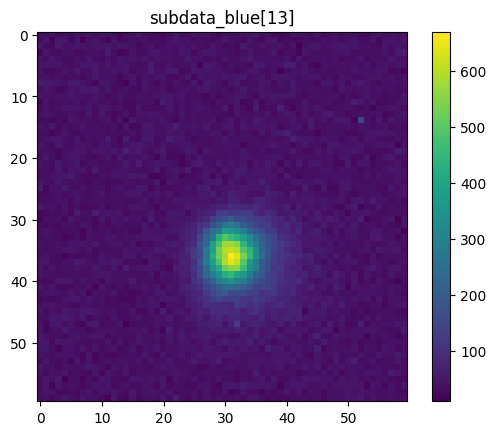

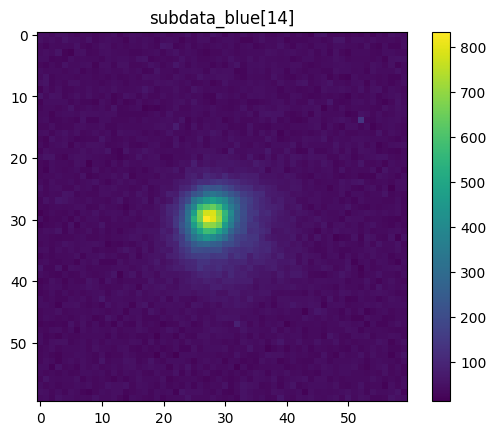

In [9]:
dir = "m57_blue/"
fits_files = sorted([f for f in os.listdir(dir) if f.startswith("m57__2025") and f.endswith(".fits")])
# Carrega os headers de todos os ficheiros
head_blue = [fits.getheader(os.path.join(dir, f)) for f in fits_files]
print("Ficheiros encontrados:")
for f in fits_files:
    print(f)


## Obtain rough position with the mouse
pos0 = [244,941] #imagem 273
pos1 = [237,924]
pos2 = [233,917]
pos3 = [233,915]
pos4 = [233,917]
pos5 = [233,917]
pos6 = [231,912]
pos7 = [228,906]
pos8 = [228,906]
pos9 = [228,906]
pos10 = [228,906]
pos11 = [224,897]
pos12 = [224,897]
pos13 = [224,897]
pos14 = [224,897] #imagem 287 (reference image for all images alignment )



positions_blue = [pos0, pos1, pos2, pos3, pos4, pos5, pos6, pos7, pos8, pos9, pos10,
             pos11, pos12, pos13, pos14]

science_dir = "m57_blue_reduced"
science_calibrated_blue = []
for file in os.listdir(science_dir):
    if file.endswith(".fits"):  
        filepath = os.path.join(science_dir, file)
        image = fits.getdata(filepath)
        science_calibrated_blue.append(image)

indices = range(len(science_calibrated_blue))        

subdata_blue = [
    science_calibrated_blue[idx][pos[1]-30:pos[1]+30, pos[0]-30:pos[0]+30]
    for idx, pos in zip(indices, positions_blue)
]

for i in range(15):  # de 0 até 14
    plt.figure()
    plt.imshow(subdata_blue[i])
    plt.title(f"subdata_blue[{i}]")
    plt.colorbar()
    plt.show()


centers_blue = {}
ccenters_blue = {}

for i, (sub, pos) in enumerate(zip(subdata_blue, positions_blue), start=0):
    centers_blue[i] = centroid_2dg(sub) + pos - [30, 30]
    ccenters_blue[i] = centroid_com(sub) + pos - [30, 30]

In [10]:
dir = "m57_blue_alignment/"

for i in range(0, 15):

    data = science_calibrated_blue[i]

    # pegar o centróide correspondente (ex: center5, center6, ...)
    center = centers_blue[i]

    # shift em y depois em x
    shifted_y = np.roll(data, -int(np.round(center[1] - center_original[1])), axis=0)
    shifted_x = np.roll(shifted_y, -int(np.round(center[0] - center_original[0])), axis=1)


    head_i = head[i]
    head_i['PROCESS'] = 'shifted'

    fits.writeto(f'{dir}m57_blue_{i}_shift.fits', shifted_x, head_i, overwrite=True)

    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


Alignment Green Filter

Ficheiros encontrados:
m57__2025-09-16_22-12-06_Green_0288.fits
m57__2025-09-16_22-12-39_Green_0289.fits
m57__2025-09-16_22-13-11_Green_0290.fits
m57__2025-09-16_22-13-44_Green_0291.fits
m57__2025-09-16_22-14-17_Green_0292.fits
m57__2025-09-16_22-14-50_Green_0293.fits
m57__2025-09-16_22-15-22_Green_0294.fits
m57__2025-09-16_22-15-55_Green_0295.fits
m57__2025-09-16_22-16-28_Green_0296.fits
m57__2025-09-16_22-17-01_Green_0297.fits
m57__2025-09-16_22-17-33_Green_0298.fits
m57__2025-09-16_22-18-06_Green_0299.fits
m57__2025-09-16_22-18-39_Green_0300.fits
m57__2025-09-16_22-19-12_Green_0301.fits
m57__2025-09-16_22-19-44_Green_0302.fits


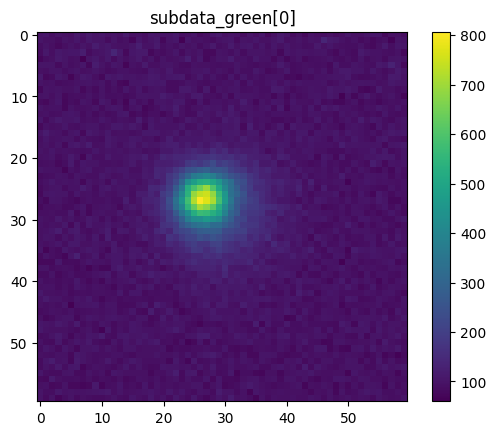

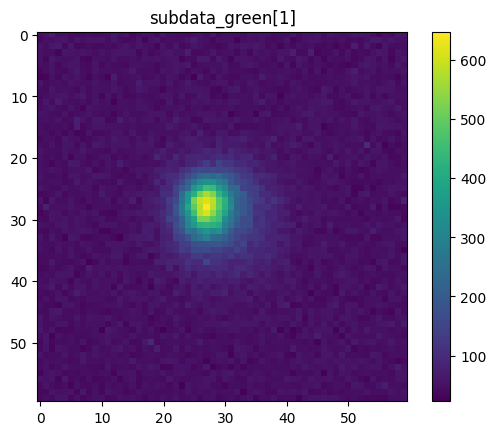

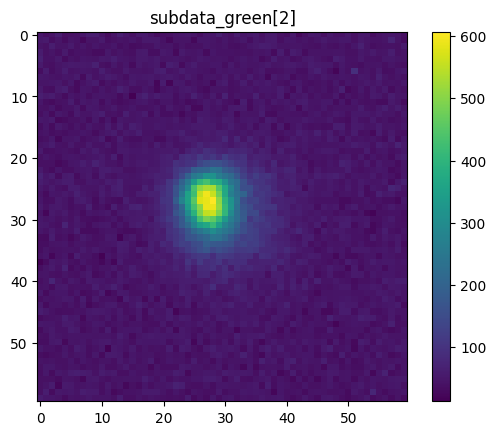

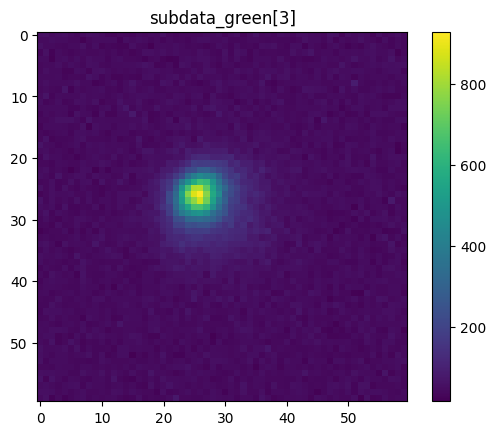

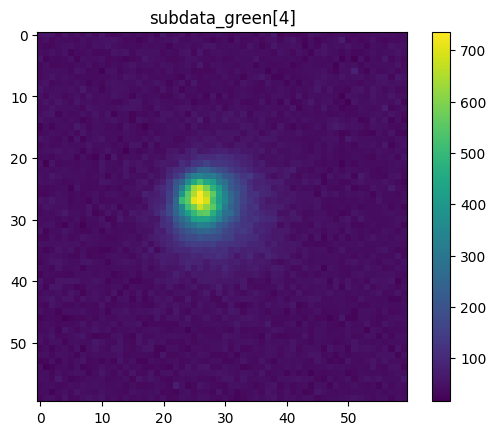

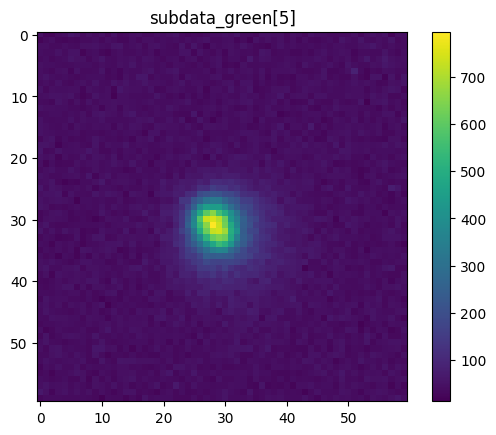

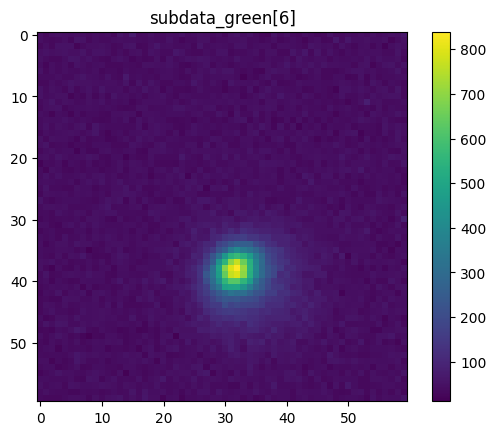

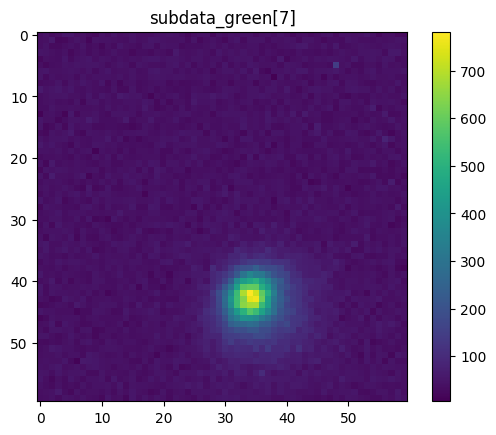

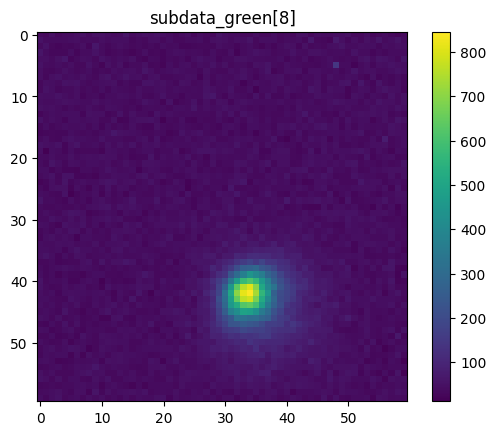

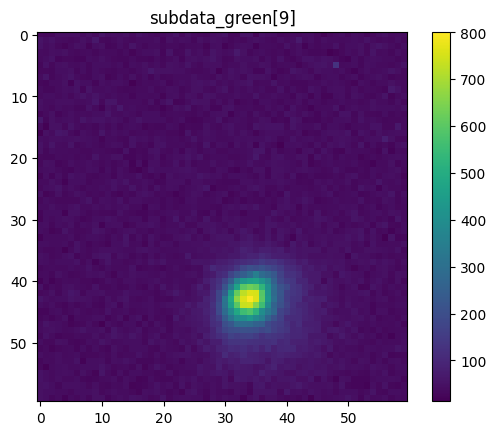

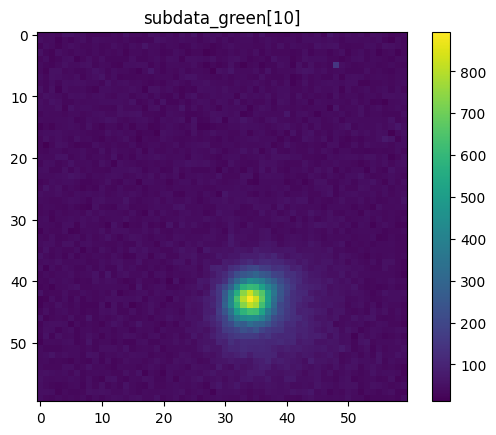

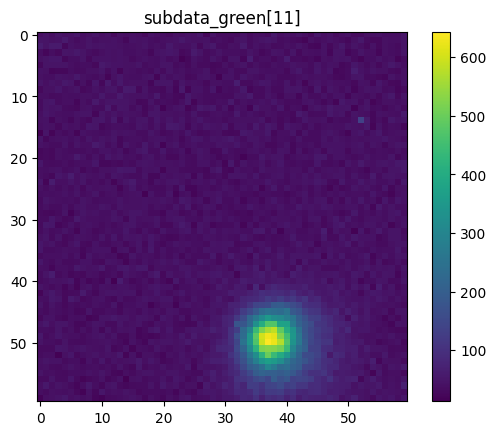

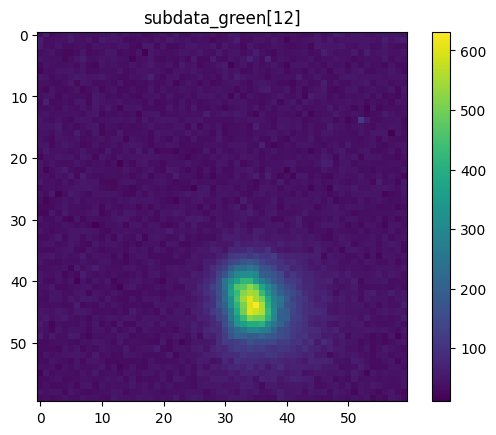

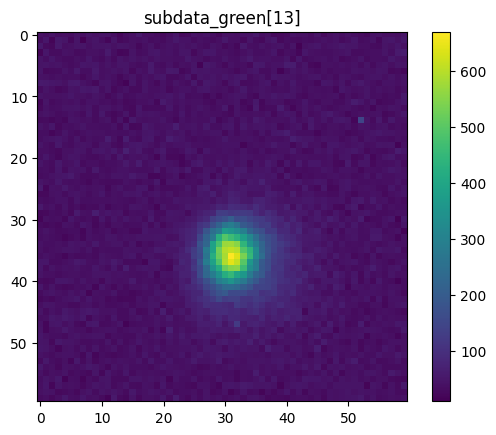

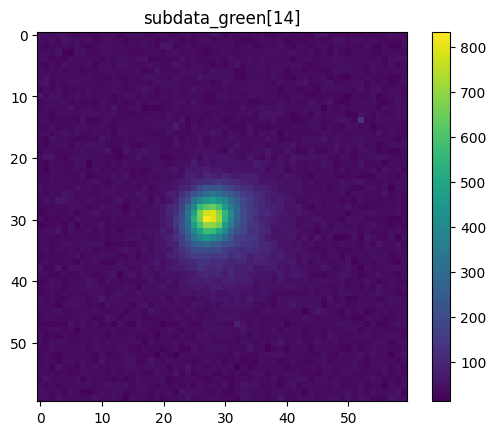

In [11]:
dir = "m57_green/"
fits_files = sorted([f for f in os.listdir(dir) if f.startswith("m57__2025") and f.endswith(".fits")])
# Carrega os headers de todos os ficheiros
head_blue = [fits.getheader(os.path.join(dir, f)) for f in fits_files]
print("Ficheiros encontrados:")
for f in fits_files:
    print(f)


## Obtain rough position with the mouse
pos0 = [234,906] #imagem 288
pos1 = [234,906]
pos2 = [234,906]
pos3 = [234,901]
pos4 = [232,896]
pos5 = [229,889]
pos6 = [224,881]
pos7 = [224,881]
pos8 = [229,886]
pos9 = [231,891]
pos10 = [231,891]
pos11 = [231,891]
pos12 = [231,889]
pos13 = [231,881] #imagem 301
pos14 = [235,886] #imagem 302



positions_green = [pos0, pos1, pos2, pos3, pos4, pos5, pos6, pos7, pos8, pos9, pos10,
             pos11, pos12, pos13, pos14]

science_dir = "m57_green_reduced"
science_calibrated_green = []
for file in os.listdir(science_dir):
    if file.endswith(".fits"):  
        filepath = os.path.join(science_dir, file)
        image = fits.getdata(filepath)
        science_calibrated_green.append(image)

indices = range(len(science_calibrated_green))

subdata_green = [
    science_calibrated_green[idx][pos[1]-30:pos[1]+30, pos[0]-30:pos[0]+30]
    for idx, pos in zip(indices, positions_green)
]

for i in range(15):  # de 0 até 14
    plt.figure()
    plt.imshow(subdata_blue[i])
    plt.title(f"subdata_green[{i}]")
    plt.colorbar()
    plt.show()


centers_green = {}
ccenters_green = {}

for i, (sub, pos) in enumerate(zip(subdata_green, positions_green), start=0):
    centers_green[i] = centroid_2dg(sub) + pos - [30, 30]
    ccenters_green[i] = centroid_com(sub) + pos - [30, 30]

In [12]:
dir = "m57_green_alignment/"

for i in range(0, 15):

    data = science_calibrated_green[i]

    # pegar o centróide correspondente (ex: center5, center6, ...)
    center = centers_green[i]

    # shift em y depois em x
    shifted_y = np.roll(data, -int(np.round(center[1] - center_original[1])), axis=0)
    shifted_x = np.roll(shifted_y, -int(np.round(center[0] - center_original[0])), axis=1)


    head_i = head[i]
    head_i['PROCESS'] = 'shifted'

    fits.writeto(f'{dir}m57_green_{i}_shift.fits', shifted_x, head_i, overwrite=True)

    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


Alignment Black Filter

Ficheiros encontrados:
m57__2025-09-16_21-47-08_black_0257.fits
m57__2025-09-16_21-49-32_black_0258.fits
m57__2025-09-16_21-50-47_black_0259.fits
m57__2025-09-16_21-51-20_black_0260.fits
m57__2025-09-16_21-51-53_black_0261.fits
m57__2025-09-16_21-52-25_black_0262.fits
m57__2025-09-16_21-52-58_black_0263.fits
m57__2025-09-16_21-53-31_black_0264.fits
m57__2025-09-16_21-54-03_black_0265.fits
m57__2025-09-16_21-54-36_black_0266.fits
m57__2025-09-16_21-55-09_black_0267.fits
m57__2025-09-16_21-55-41_black_0268.fits
m57__2025-09-16_21-56-14_black_0269.fits
m57__2025-09-16_21-56-47_black_0270.fits
m57__2025-09-16_21-57-19_black_0271.fits
m57__2025-09-16_21-57-52_black_0272.fits


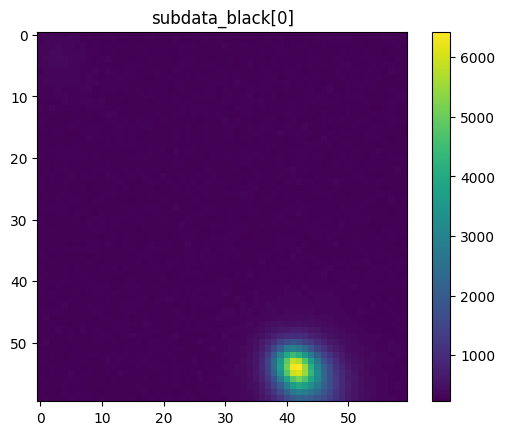

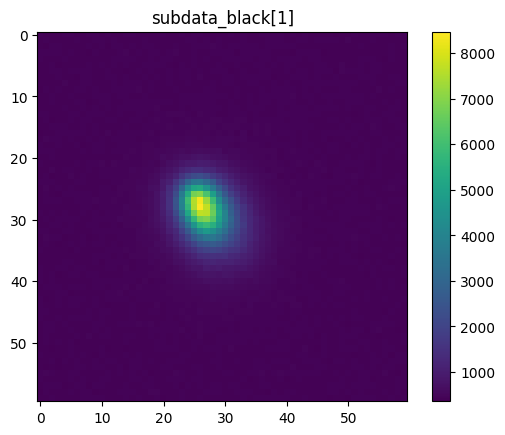

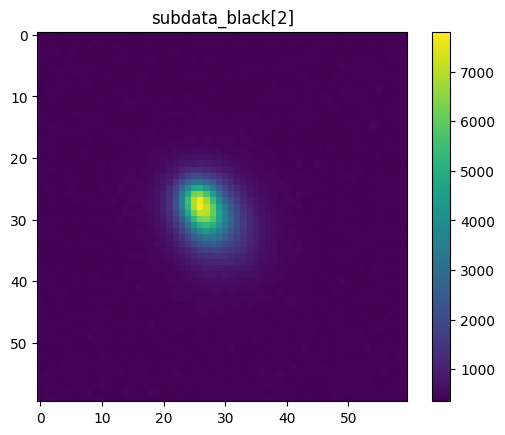

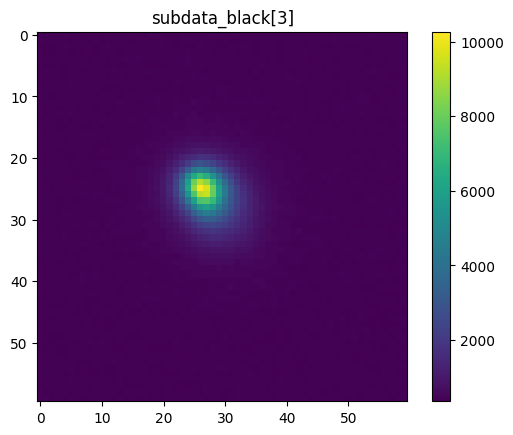

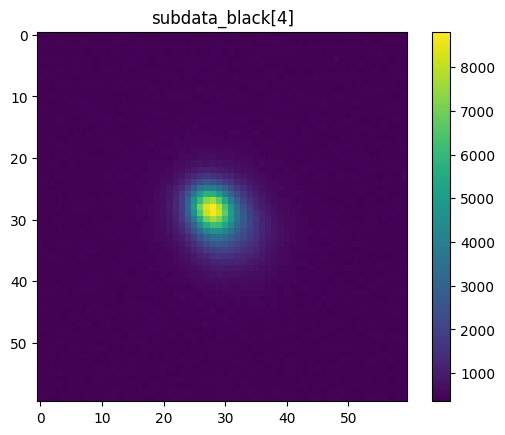

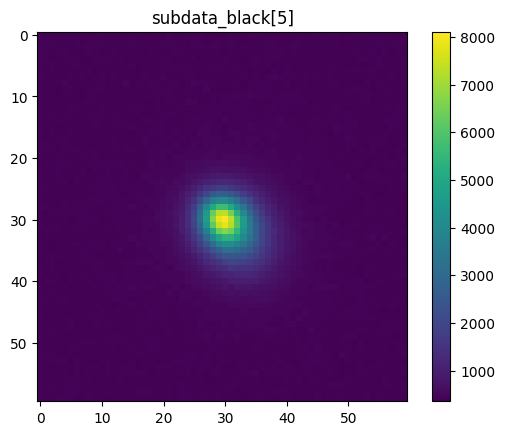

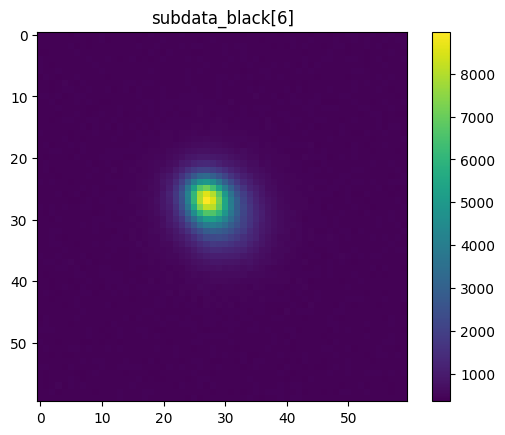

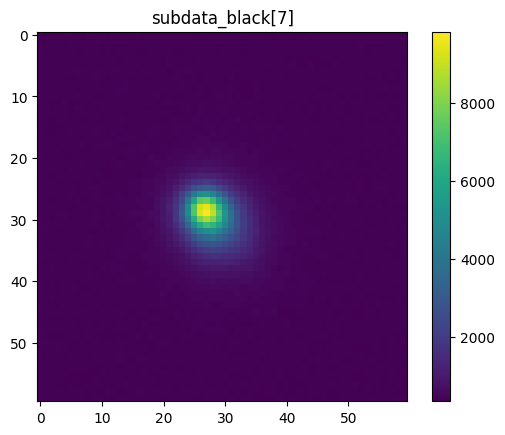

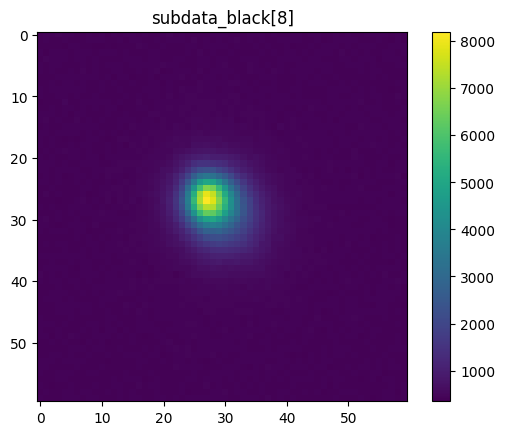

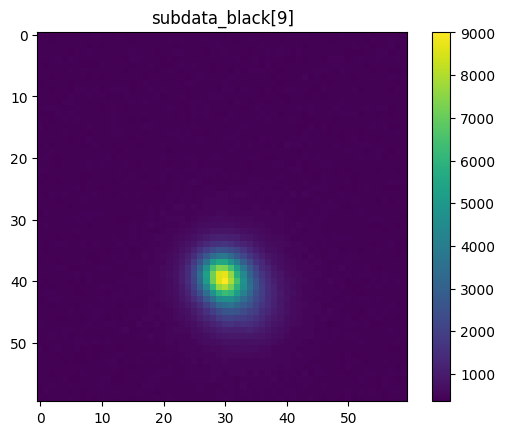

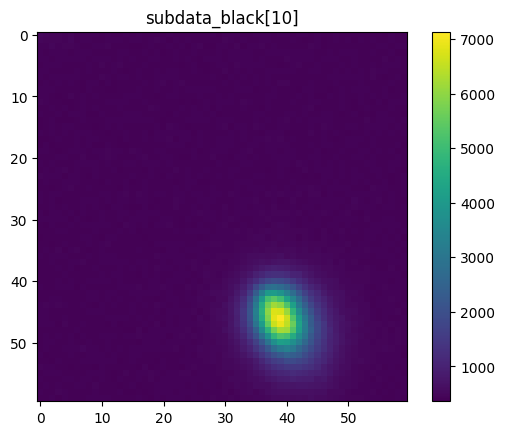

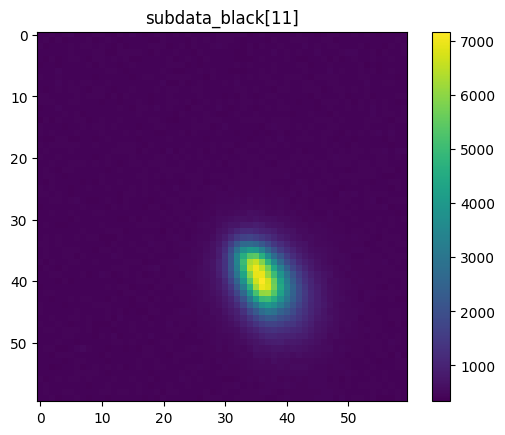

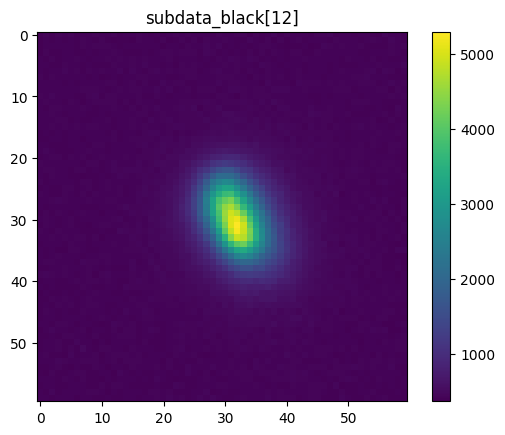

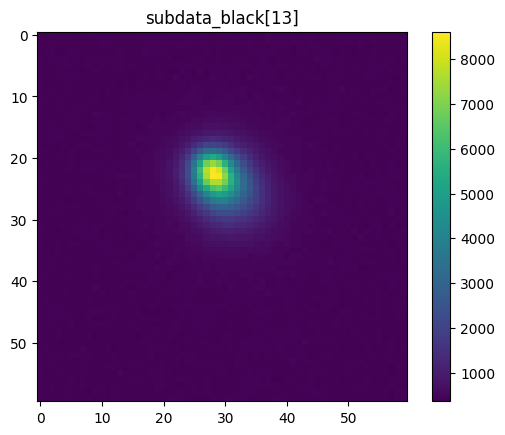

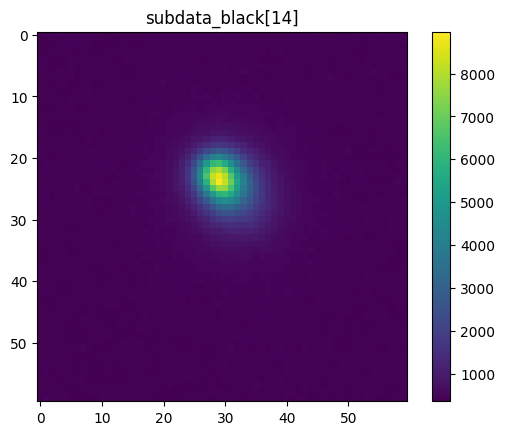

In [13]:
dir = "m57_black/"
fits_files = sorted([f for f in os.listdir(dir) if f.startswith("m57__2025") and f.endswith(".fits")])
# Carrega os headers de todos os ficheiros
head_blue = [fits.getheader(os.path.join(dir, f)) for f in fits_files]
print("Ficheiros encontrados:")
for f in fits_files:
    print(f)


## Obtain rough position with the mouse
pos0 = [249,966] #imagem 258
pos1 = [251,966]
pos2 = [251,966]
pos3 = [251,966]
pos4 = [251,966]
pos5 = [251,966]
pos6 = [251,966]
pos7 = [251,963]
pos8 = [251,963]
pos9 = [246,948]
pos10 = [236,936]
pos11 = [236,936]
pos12 = [236,936]
pos13 = [236,936]
pos14 = [236,936] #imagem 272



positions_black = [pos0, pos1, pos2, pos3, pos4, pos5, pos6, pos7, pos8, pos9, pos10,
             pos11, pos12, pos13, pos14]

science_dir = "m57_black_reduced"
science_calibrated_black = []
for file in os.listdir(science_dir):
    if file.endswith(".fits"):  
        filepath = os.path.join(science_dir, file)
        image = fits.getdata(filepath)
        science_calibrated_black.append(image)

indices = range(len(science_calibrated_black))

subdata_black = [
    science_calibrated_black[idx][pos[1]-30:pos[1]+30, pos[0]-30:pos[0]+30]
    for idx, pos in zip(indices, positions_black)
]

for i in range(15):  # de 0 até 14
    plt.figure()
    plt.imshow(subdata_black[i])
    plt.title(f"subdata_black[{i}]")
    plt.colorbar()
    plt.show()


centers_black = {}
ccenters_black = {}

for i, (sub, pos) in enumerate(zip(subdata_black, positions_black), start=0):
    centers_black[i] = centroid_2dg(sub) + pos - [30, 30]
    ccenters_black[i] = centroid_com(sub) + pos - [30, 30]

In [14]:
dir = "m57_black_alignment/"

for i in range(0, 15):

    data = science_calibrated_black[i]

    # pegar o centróide correspondente (ex: center5, center6, ...)
    center = centers_black[i]

    # shift em y depois em x
    shifted_y = np.roll(data, -int(np.round(center[1] - center_original[1])), axis=0)
    shifted_x = np.roll(shifted_y, -int(np.round(center[0] - center_original[0])), axis=1)


    head_i = head[i]
    head_i['PROCESS'] = 'shifted'

    fits.writeto(f'{dir}m57_black_{i}_shift.fits', shifted_x, head_i, overwrite=True)

    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
